<a href="https://colab.research.google.com/github/ddlandim/DS-BirminghamCardTransactions/blob/main/BirminghamCC_PurchaseCardTransactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Birmingham City Council - Purchase Card Transactions

In this dataset you have a collection of purchase card transactions for the Birmingham City Council. https://data.birmingham.gov.uk/dataset/purchase-card-transactions. This is a historical dataset, you’re able to perform any of the following tasks:
	
- (Clustering) Discovering profiles (whether the case) or unusual transactions  
(anomalies detection) ...  

- (Forecasting) Try to guess future transactional behaviors. For instance, what would be the next purchase? Expenditures forecasting? ...  

- (Creativity) State a problem.


It’s up to you defining the time window in which your analysis will take place.

To do so, we suggest you create a notebook, like Jupyter (if you use python) or a Rmarkdown report (in case you use R) and make it available.
 
Hint to success in your quest:  
Develop and state clear of the data science process you'll perform over the dataset and highlight important aspects you might consider affordable to discuss over. Use the mindset of a business and curious consultant.

# Considerations
The origin of our dataset is a municipal chamber.
The data are distributed in excel spreadsheets, 1 per month from 2014 to 2018, with a few months missing.  

Opening 1 of the files, it can be verified that the records contain transactions per person, which will be identified by the end of the credit card, the transaction is accompanied by the value, date, and identifiers of the supplier and classifiers of the activity and type of product of this supplier.

As we have a dataset of corporate cards, perhaps the council interest is to discover corporate frauds such as purchases of products with overpriced values, and forecasts of expenses per person.

# 1 - Goals
- Discover profiles: clustering by people / clustering by product type / unusual transactions.  

-	Guess future transactional behaviours / forecasting.

# 2 - Data management

-	Imported data by year in different DataFrames.
-	Indexed the rows by the dates using “TRANS DATE” variable
-	Added the year 2015 in the name of the corresponding files.


## System setup

In [1]:
import os
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.arima_model import ARIMA

from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate

In [2]:
! pip install pmdarima

In [4]:
from pmdarima.arima import auto_arima

## Dataset import

### Util functions

In [5]:
mo_list = ["january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december"]

In [6]:
def xlsDataImport(file_list, key):
  df = pd.DataFrame()
  mi_list = mo_list.copy()
  counter = 0
  for pos, filename in enumerate(file_list): 
    if filename.endswith(".xls") and key in filename:
      counter+=1
      df = df.append(pd.read_excel(filename, index_col = 'TRANS DATE', parse_dates = True))
      print(counter,pos,filename)
      for mo in mi_list:
        #if mo in filename or mo[1:3] in filename:
          if mo in filename:
            mi_list.remove(mo)
  print("missing months", mi_list)
  return df

I downloaded all the spreadsheets from the link provided, to avoid problems with future data unavailability, and made it available in a compressed file in my github repository.
No spreadsheets have been changed in content or name.

In [7]:
!mkdir Dataset


In [8]:
cwd = os.chdir('Dataset')

In [9]:
!wget https://github.com/ddlandim/DS-BirminghamCardTransactions/raw/main/Dataset/Dataset.zip

--2021-02-01 13:58:13--  https://github.com/ddlandim/DS-BirminghamCardTransactions/raw/main/Dataset/Dataset.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ddlandim/DS-BirminghamCardTransactions/main/Dataset/Dataset.zip [following]
--2021-02-01 13:58:14--  https://raw.githubusercontent.com/ddlandim/DS-BirminghamCardTransactions/main/Dataset/Dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8415367 (8.0M) [application/zip]
Saving to: ‘Dataset.zip’

Dataset.zip         100%[===================>]   8.03M  29.1MB/s    in 0.3s    

2021-02-01 13:58:15 (29.1 MB/s) - ‘Dataset.zip’ saved [84153

In [10]:
!rm *.xls

rm: cannot remove '*.xls': No such file or directory


In [11]:
!unzip Dataset.zip

Archive:  Dataset.zip
  inflating: cusersfinainmndesktoppublish-copy-january-2017.xls  
  inflating: cusersfinainmndesktoppublish-spend-august-2017-all-directorates.xls  
  inflating: cusersfinainmndesktoppublish-spend-february-2017-all-directorates.xls  
  inflating: cusersfinainmndesktoppublish-spend-january-2018.xls  
  inflating: cusersfinainmndesktoppublish-spend-july-2017.xls  
  inflating: cusersfinainmndesktoppublish-spend-june--2017.xls  
  inflating: cusersfinainmndesktoppublish-spend-march-2017.xls  
  inflating: cusersfinainmndesktoppublish-spend-may-2017.xls  
  inflating: cusersfinainmndesktoppublish-spend-november-2017-all-directorates.xls  
  inflating: cusersfinainmndesktoppublish-spend-october-2017-all-directorates.xls  
  inflating: cusersfinainmndesktoppublish-spend-sept-2017.xls  
  inflating: itemisedtransactionsaugust2015publishspendalldirectorates.xls  
  inflating: itemisedtransactionsjuly2015publishspend.xls  
  inflating: open_data_planning_weekly_list.csv  


In [12]:
file_list = os.listdir(cwd)
print(file_list)

['publishspendnovember2015.xls', 'publishspendoctober2015.xls', 'purchasecardtransactionsjune2014.xls', 'publishspendjune2015alldirectorates.xls', 'purchaseccardtransactionsjanuary2015.xls', 'itemisedtransactionsaugust2015publishspendalldirectorates.xls', 'purchasecardtransactionsapril2014.xls', 'publish-spend-december-2016.xls', 'Dataset.zip', 'publish-spend-june-2016.xls', 'svlrdclr05homesharechexefinainmngeneralappublishspendmay2015.xls', 'cusersfinainmndesktoppublish-spend-march-2017.xls', 'cusersfinainmndesktoppublish-spend-may-2017.xls', 'purchasecardtransactionsmay2014.xls', 'publishspendpurchasecardsfebruary.xls', 'publishspendfebruary2016.xls', 'publishspendpurchasecardsmarch.xls', 'open_data_planning_weekly_list.csv', 'purchasecardsnov2014.xls', 'cusersfinainmndesktoppublish-spend-october-2017-all-directorates.xls', 'cusersfinainmndesktoppublish-spend-november-2017-all-directorates.xls', 'publish-spend-april-2016.xls', 'purchasecardtransactionsaugust2014.xls', 'itemisedtransa

### 2014
Importing files

In [13]:
df2014 = xlsDataImport(file_list,"2014")

1 2 purchasecardtransactionsjune2014.xls
2 6 purchasecardtransactionsapril2014.xls
3 13 purchasecardtransactionsmay2014.xls
4 18 purchasecardsnov2014.xls
5 22 purchasecardtransactionsaugust2014.xls
6 29 purchasecardtransactionsjuly2014.xls
7 30 purchasecardtransactionsoctober2014.xls
8 33 purchasecardsdec2014.xls
9 36 purchasecardtransactionsseptember2014.xls
missing months ['january', 'february', 'march', 'november', 'december']


2014 files start in April and as we can see november and december have their names abbreviated so we can move on

In [14]:
df2014

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,BILLING CUR CODE,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
TRANS DATE,,,,,,,,,,,
2014-07-01,VR,59.99,shell kings 587,************5770,GBP,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities
2014-06-10,VR,77.49,shell kings 587,************5770,GBP,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities
2014-06-27,VR,48.66,acocks green 224,************8143,GBP,K020,Vehicle Fuel,RV14R,Mobile Night Care Service,A00,Adult & Communities
2014-06-16,VR,3.00,bristol street ser,************8143,GBP,K020,Vehicle Fuel,RV14R,Mobile Night Care Service,A00,Adult & Communities
2014-07-01,VR,53.17,tesco pfs 2484,************8738,GBP,K020,Vehicle Fuel,RV11Y,"Marsh Lane Dce, 79, B23",A00,Adult & Communities
...,...,...,...,...,...,...,...,...,...,...,...
2014-09-09,VR,49918.10,the furnishing service,************6583,GBP,L100,Equip Operational,RYB5F,Social Fund,A00,Corporate Resources
2014-09-05,VR,46667.53,the furnishing service,************6583,GBP,L100,Equip Operational,RYB5F,Social Fund,A00,Corporate Resources
2014-09-24,VR,446.10,the furnishing service,************5339,GBP,L100,Equip Operational,RVB0A,Harriet Louisa Loxton Trust(ex5000,A00,Adults & Comms


### 2015
importing files

In [15]:
df2015 = xlsDataImport(file_list,"2015")

1 0 publishspendnovember2015.xls
2 1 publishspendoctober2015.xls
3 3 publishspendjune2015alldirectorates.xls
4 4 purchaseccardtransactionsjanuary2015.xls
5 5 itemisedtransactionsaugust2015publishspendalldirectorates.xls
6 10 svlrdclr05homesharechexefinainmngeneralappublishspendmay2015.xls
7 23 itemisedtransactionsjuly2015publishspend.xls
8 27 publishedspenddecember2015.xls
9 32 publishspendseptember2015.xls
missing months ['february', 'march', 'april']


missing: 
 - feb (present in datafiles, but without '2015' in filename)
 - mar (present in datafiles, but without '2015' in filename)
 - apr (not present in datafiles provided)

 manual include of feb,mar

In [16]:
df2015

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,Directorate
TRANS DATE,,,,,,,,,,,
2015-11-26,VR,27.73,shell harborne,************8143,K020,Vehicle Fuel,RV14R,Mobile Night Care Service,A00,Adult & Communities,NaN
2015-11-05,VR,44.81,tex sussex sstn,************8738,K020,Vehicle Fuel,RV12T,"Shakti Elders Dce, 73 Conybere St, B12",A00,Adult & Communities,NaN
2015-11-17,VR,48.58,tex sussex sstn,************8738,K020,Vehicle Fuel,RV12T,"Shakti Elders Dce, 73 Conybere St, B12",A00,Adult & Communities,NaN
2015-11-24,VR,49.25,tex sussex sstn,************8738,K020,Vehicle Fuel,RV12T,"Shakti Elders Dce, 73 Conybere St, B12",A00,Adult & Communities,NaN
2015-11-30,VR,69.40,tex sussex sstn,************8738,K020,Vehicle Fuel,RV12T,"Shakti Elders Dce, 73 Conybere St, B12",A00,Adult & Communities,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2015-09-17,VR,208.00,the vac clinic,************8673,L100,Equip Operational,RJHH8,Homeless Centre-Breedon Road,A00,Local Services,NaN
2015-09-15,VR,515.00,britannia,************8673,J250,Accomodation Hire,RJACG,H/Less Temporary Accomdtn Team,A00,Local Services,NaN
2015-09-11,VZ,34.65,travelodge,************8673,J250,Accomodation Hire,RJACG,H/Less Temporary Accomdtn Team,A00,Local Services,NaN


In [17]:
df2015_feb = pd.read_excel('publishspendpurchasecardsfebruary.xls', index_col = 'TRANS DATE', parse_dates = True)
df2015_mar = pd.read_excel('publishspendpurchasecardsmarch.xls', index_col = 'TRANS DATE', parse_dates = True)

In [18]:
df2015_feb

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Unnamed: 10
TRANS DATE,,,,,,,,,,
2015-02-24,VR,54.75,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities
2015-02-03,VR,51.64,tesco pfs 2484,************8738,K020,Vehicle Fuel,RV11Y,"Marsh Lane Dce, 79, B23",A00,Adult & Communities
2015-02-12,VR,43.89,tesco pfs 2484,************8738,K020,Vehicle Fuel,RV11Y,"Marsh Lane Dce, 79, B23",A00,Adult & Communities
2015-02-04,VR,54.00,blood pressure ass,************7557,H2T0,Training Other,RVA0K,Admin Support,A00,Adult & Communities
2015-02-07,VZ,6.99,viewbix,************7557,H000,Staff Advert Exp,RVA0K,Admin Support,A00,Adult & Communities
...,...,...,...,...,...,...,...,...,...,...
2015-02-04,VR,40.05,tesco pfs 3953,************8527,K020,Vehicle Fuel,RHBC7,Erdington CBH03 Neigh C'takers,A00,Local Services
2015-02-19,VR,82.65,tesco pfs 3953,************8527,K020,Vehicle Fuel,RHBC7,Erdington CBH03 Neigh C'takers,A00,Local Services
2015-03-02,VR,83.59,tesco pfs 4203,************6790,K020,Vehicle Fuel,RHEE7,Ladywood CBH05 Neigh C'takers,A00,Local Services


In [19]:
df2015_feb.rename(columns={"Unnamed: 10" : "Directorate"})

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
TRANS DATE,,,,,,,,,,
2015-02-24,VR,54.75,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities
2015-02-03,VR,51.64,tesco pfs 2484,************8738,K020,Vehicle Fuel,RV11Y,"Marsh Lane Dce, 79, B23",A00,Adult & Communities
2015-02-12,VR,43.89,tesco pfs 2484,************8738,K020,Vehicle Fuel,RV11Y,"Marsh Lane Dce, 79, B23",A00,Adult & Communities
2015-02-04,VR,54.00,blood pressure ass,************7557,H2T0,Training Other,RVA0K,Admin Support,A00,Adult & Communities
2015-02-07,VZ,6.99,viewbix,************7557,H000,Staff Advert Exp,RVA0K,Admin Support,A00,Adult & Communities
...,...,...,...,...,...,...,...,...,...,...
2015-02-04,VR,40.05,tesco pfs 3953,************8527,K020,Vehicle Fuel,RHBC7,Erdington CBH03 Neigh C'takers,A00,Local Services
2015-02-19,VR,82.65,tesco pfs 3953,************8527,K020,Vehicle Fuel,RHBC7,Erdington CBH03 Neigh C'takers,A00,Local Services
2015-03-02,VR,83.59,tesco pfs 4203,************6790,K020,Vehicle Fuel,RHEE7,Ladywood CBH05 Neigh C'takers,A00,Local Services


In [20]:
df2015_mar

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
TRANS DATE,,,,,,,,,,
2015-03-08,VR,35.96,fasthosts internet,************3497,L9Y0,Computing Other,RV3VG,AD Adults Strategy,A00,Adult & Communities
2015-03-23,VR,12.24,fast key services,************4094,L100,Equip Operational,RV3A7,Hodge Hill Adult Team,A00,Adult & Communities
2015-03-22,VR,52.45,acocks green 224,************4302,K020,Vehicle Fuel,RV14R,Mobile Night Care Service,A00,Adult & Communities
2015-03-09,VR,40.66,esso aston way ss,************6316,K020,Vehicle Fuel,RV14R,Mobile Night Care Service,A00,Adult & Communities
2015-03-29,VR,59.57,esso aston way ss,************1287,K020,Vehicle Fuel,RV14R,Mobile Night Care Service,A00,Adult & Communities
...,...,...,...,...,...,...,...,...,...,...
2015-03-31,VR,66.95,selco trade centres,************3949,J030,Bldg RM Departmental,RLBCC,Alexander Stadium,A00,Local Services
2015-03-31,VR,25.90,selco trade centres,************3949,J030,Bldg RM Departmental,RLBCC,Alexander Stadium,A00,Local Services
2015-03-31,VR,19.18,selco trade centres,************3949,J030,Bldg RM Departmental,RLBCC,Alexander Stadium,A00,Local Services


In [21]:
df2015 = df2015.append(df2015_feb)
df2015 = df2015.append(df2015_mar)
df2015

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,Directorate,Unnamed: 10
TRANS DATE,,,,,,,,,,,,
2015-11-26,VR,27.73,shell harborne,************8143,K020,Vehicle Fuel,RV14R,Mobile Night Care Service,A00,Adult & Communities,NaN,NaN
2015-11-05,VR,44.81,tex sussex sstn,************8738,K020,Vehicle Fuel,RV12T,"Shakti Elders Dce, 73 Conybere St, B12",A00,Adult & Communities,NaN,NaN
2015-11-17,VR,48.58,tex sussex sstn,************8738,K020,Vehicle Fuel,RV12T,"Shakti Elders Dce, 73 Conybere St, B12",A00,Adult & Communities,NaN,NaN
2015-11-24,VR,49.25,tex sussex sstn,************8738,K020,Vehicle Fuel,RV12T,"Shakti Elders Dce, 73 Conybere St, B12",A00,Adult & Communities,NaN,NaN
2015-11-30,VR,69.40,tex sussex sstn,************8738,K020,Vehicle Fuel,RV12T,"Shakti Elders Dce, 73 Conybere St, B12",A00,Adult & Communities,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-03-31,VR,66.95,selco trade centres,************3949,J030,Bldg RM Departmental,RLBCC,Alexander Stadium,A00,Local Services,NaN,NaN
2015-03-31,VR,25.90,selco trade centres,************3949,J030,Bldg RM Departmental,RLBCC,Alexander Stadium,A00,Local Services,NaN,NaN
2015-03-31,VR,19.18,selco trade centres,************3949,J030,Bldg RM Departmental,RLBCC,Alexander Stadium,A00,Local Services,NaN,NaN


In [22]:
df2015 = df2015.iloc[:, :-2]
df2015

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
TRANS DATE,,,,,,,,,,
2015-11-26,VR,27.73,shell harborne,************8143,K020,Vehicle Fuel,RV14R,Mobile Night Care Service,A00,Adult & Communities
2015-11-05,VR,44.81,tex sussex sstn,************8738,K020,Vehicle Fuel,RV12T,"Shakti Elders Dce, 73 Conybere St, B12",A00,Adult & Communities
2015-11-17,VR,48.58,tex sussex sstn,************8738,K020,Vehicle Fuel,RV12T,"Shakti Elders Dce, 73 Conybere St, B12",A00,Adult & Communities
2015-11-24,VR,49.25,tex sussex sstn,************8738,K020,Vehicle Fuel,RV12T,"Shakti Elders Dce, 73 Conybere St, B12",A00,Adult & Communities
2015-11-30,VR,69.40,tex sussex sstn,************8738,K020,Vehicle Fuel,RV12T,"Shakti Elders Dce, 73 Conybere St, B12",A00,Adult & Communities
...,...,...,...,...,...,...,...,...,...,...
2015-03-31,VR,66.95,selco trade centres,************3949,J030,Bldg RM Departmental,RLBCC,Alexander Stadium,A00,Local Services
2015-03-31,VR,25.90,selco trade centres,************3949,J030,Bldg RM Departmental,RLBCC,Alexander Stadium,A00,Local Services
2015-03-31,VR,19.18,selco trade centres,************3949,J030,Bldg RM Departmental,RLBCC,Alexander Stadium,A00,Local Services


### 2016
January to December

In [23]:
df2016 = xlsDataImport(file_list,"2016")

1 7 publish-spend-december-2016.xls
2 9 publish-spend-june-2016.xls
3 15 publishspendfebruary2016.xls
4 21 publish-spend-april-2016.xls
5 26 publish-spend-august-2016.xls
6 28 publish-spend-october-2016.xls
7 31 publish-spend-september-2016.xls
8 34 publishspendjanuary2016.xls
9 37 publishspendmarch2016.xls
10 38 publishing-spend-november-2016.xls
11 40 publish-spend-may-2016.xls
12 43 publish-spend-july-2016.xls
missing months []


In [24]:
df2016

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,Directorates
TRANS DATE,,,,,,,,,,,
2016-12-22,VR,20.00,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities,NaN
2016-12-15,VR,35.00,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities,NaN
2016-12-22,VR,75.97,shell fiveways 387,************1147,K020,Vehicle Fuel,RV1K2,Elders Group - Ladywood,A00,Adult & Communities,NaN
2016-12-21,VR,50.00,shell fiveways 387,************1147,K020,Vehicle Fuel,RV1K2,Elders Group - Ladywood,A00,Adult & Communities,NaN
2016-12-21,VR,47.24,shell fiveways 387,************1147,K020,Vehicle Fuel,RV1K2,Elders Group - Ladywood,A00,Adult & Communities,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2016-07-31,VR,60.00,premier inn,************7751,M900,Hospitality,RHNCA,Careline,A00,Local Services,NaN
2016-07-31,VR,60.00,premier inn,************7751,M900,Hospitality,RHNCA,Careline,A00,Local Services,NaN
2016-07-04,VR,48.50,jacksons services ltd,************4599,K020,Vehicle Fuel,RHNCA,Careline,A00,Local Services,NaN


In [25]:
df2016 = df2016.drop('Directorates',axis=1)
df2016

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
TRANS DATE,,,,,,,,,,
2016-12-22,VR,20.00,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities
2016-12-15,VR,35.00,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities
2016-12-22,VR,75.97,shell fiveways 387,************1147,K020,Vehicle Fuel,RV1K2,Elders Group - Ladywood,A00,Adult & Communities
2016-12-21,VR,50.00,shell fiveways 387,************1147,K020,Vehicle Fuel,RV1K2,Elders Group - Ladywood,A00,Adult & Communities
2016-12-21,VR,47.24,shell fiveways 387,************1147,K020,Vehicle Fuel,RV1K2,Elders Group - Ladywood,A00,Adult & Communities
...,...,...,...,...,...,...,...,...,...,...
2016-07-31,VR,60.00,premier inn,************7751,M900,Hospitality,RHNCA,Careline,A00,Local Services
2016-07-31,VR,60.00,premier inn,************7751,M900,Hospitality,RHNCA,Careline,A00,Local Services
2016-07-04,VR,48.50,jacksons services ltd,************4599,K020,Vehicle Fuel,RHNCA,Careline,A00,Local Services


### 2017
January to December

In [26]:
df2017 = xlsDataImport(file_list,"2017")

1 11 cusersfinainmndesktoppublish-spend-march-2017.xls
2 12 cusersfinainmndesktoppublish-spend-may-2017.xls
3 19 cusersfinainmndesktoppublish-spend-october-2017-all-directorates.xls
4 20 cusersfinainmndesktoppublish-spend-november-2017-all-directorates.xls
5 24 cusersfinainmndesktoppublish-spend-august-2017-all-directorates.xls
6 25 cusersfinainmndesktoppublish-copy-january-2017.xls
7 35 cusersfinainmndesktoppublish-spend-sept-2017.xls
8 39 cusersfinainmndesktoppublish-spend-february-2017-all-directorates.xls
9 41 cusersfinainmndesktoppublish-spend-july-2017.xls
10 44 cusersfinainmndesktoppublish-spend-june--2017.xls
missing months ['april', 'september', 'december']


missing: december is provided as csv file with different features, so for now we bypass this file, april is not provided and sept is abreviated

In [27]:
df2017

,TRANS VAT DESC,ORIGINAL GROSS AMT,ORIGINAL CUR,BILLING GROSS AMT,BILLING CUR CODE,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,Directorates,TRANS TAX AMT,BILLING CUR CODE.1
TRANS DATE,,,,,,,,,,,,,,,,
2017-03-21,VR,26.15,GBP,26.15,GBP,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities,NaN,NaN,NaN
2017-03-23,VR,78.72,GBP,78.72,GBP,shell fiveways 387,************1147,K020,Vehicle Fuel,RV1K2,Elders Group - Ladywood,A00,Adult & Communities,NaN,NaN,NaN
2017-03-23,VR,68.00,GBP,68.00,GBP,shell fiveways 387,************1147,K020,Vehicle Fuel,RV1K2,Elders Group - Ladywood,A00,Adult & Communities,NaN,NaN,NaN
2017-03-21,VR,75.20,GBP,75.20,GBP,tesco pfs 4203,************1147,K020,Vehicle Fuel,RV1K2,Elders Group - Ladywood,A00,Adult & Communities,NaN,NaN,NaN
2017-03-17,VR,15.00,GBP,15.00,GBP,the gate fuels ltd,************1147,K020,Vehicle Fuel,RV1K2,Elders Group - Ladywood,A00,Adult & Communities,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-23,VR,146.00,GBP,146.00,GBP,travelodge gb0000,************7751,N060,Other Third Parties,RJADC,Homeless Private Sector Accom,A00,Local Services,NaN,NaN,NaN
2017-06-21,VR,82.00,GBP,82.00,GBP,travelodge gb0000,************7751,N060,Other Third Parties,RJADC,Homeless Private Sector Accom,A00,Local Services,NaN,NaN,NaN
2017-06-21,VR,82.00,GBP,82.00,GBP,travelodge gb0000,************7751,N060,Other Third Parties,RJADC,Homeless Private Sector Accom,A00,Local Services,NaN,NaN,NaN


### 2018
January

In [28]:
df2018 = xlsDataImport(file_list,"2018")

1 42 cusersfinainmndesktoppublish-spend-january-2018.xls
missing months ['february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']


In [29]:
df2018

,TRANS VAT DESC,ORIGINAL GROSS AMT,ORIGINAL CUR,BILLING GROSS AMT,BILLING CUR CODE,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
TRANS DATE,,,,,,,,,,,,,
2018-01-03,VR,82.20,GBP,82.20,GBP,mrh six ways,************5804,K020,Vehicle Fuel,RVA11,Beeches GOLDD,A00,Adult Social Care and Health
2018-02-05,VR,60.00,GBP,60.00,GBP,malthurst limited,************5804,K020,Vehicle Fuel,RVA11,Beeches GOLDD,A00,Adult Social Care and Health
2018-01-29,VR,50.00,GBP,50.00,GBP,beeches road servi,************5804,K020,Vehicle Fuel,RVA11,Beeches GOLDD,A00,Adult Social Care and Health
2018-01-19,VR,45.00,GBP,45.00,GBP,beeches road servi,************5804,K020,Vehicle Fuel,RVA11,Beeches GOLDD,A00,Adult Social Care and Health
2018-01-18,VR,77.49,GBP,77.49,GBP,rontec moseley,************2823,K020,Vehicle Fuel,RV191,Moseley Day Centre,A00,Adult Social Care and Health
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-10,VR,63.83,GBP,63.83,GBP,bp clock f/s,************4599,K020,Vehicle Fuel,RHNCA,Careline,A00,Local Services
2018-02-02,VR,34.64,GBP,34.64,GBP,sparkbrook service,************4599,K020,Vehicle Fuel,RHNCA,Careline,A00,Local Services
2018-01-24,VR,48.01,GBP,48.01,GBP,malthurst limited,************2150,K020,Vehicle Fuel,RTG15,Enforcement Team,A00,Local Services


# 3 -	Pre-processing

Profiling / clustering
Based on people's transactions

-	Remove rows containing NaN values.
-	 Ordered values by the ascending dates.
-	Scaled the numerical variables so they will have a means of 0 and a standard deviation of 1.


### Entire dataset

So now we have this dataframes:  
- df2014
- df2015
- df2016
- df2017
- df2018

In [30]:
df2014.head(1)

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,BILLING CUR CODE,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
TRANS DATE,,,,,,,,,,,
2014-07-01,VR,59.99,shell kings 587,************5770,GBP,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities


In [31]:
df2015.head(1)

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
TRANS DATE,,,,,,,,,,
2015-11-26,VR,27.73,shell harborne,************8143,K020,Vehicle Fuel,RV14R,Mobile Night Care Service,A00,Adult & Communities


In [32]:
df2016.head(1)

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
TRANS DATE,,,,,,,,,,
2016-12-22,VR,20.0,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities


In [33]:
df2017.head(1)

,TRANS VAT DESC,ORIGINAL GROSS AMT,ORIGINAL CUR,BILLING GROSS AMT,BILLING CUR CODE,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,Directorates,TRANS TAX AMT,BILLING CUR CODE.1
TRANS DATE,,,,,,,,,,,,,,,,
2017-03-21,VR,26.15,GBP,26.15,GBP,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities,NaN,NaN,NaN


In [34]:
df2017.drop('Directorates', axis=1, inplace=True)
df2017.head(1)

,TRANS VAT DESC,ORIGINAL GROSS AMT,ORIGINAL CUR,BILLING GROSS AMT,BILLING CUR CODE,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,TRANS TAX AMT,BILLING CUR CODE.1
TRANS DATE,,,,,,,,,,,,,,,
2017-03-21,VR,26.15,GBP,26.15,GBP,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities,NaN,NaN


In [35]:
df2018.head(1)

,TRANS VAT DESC,ORIGINAL GROSS AMT,ORIGINAL CUR,BILLING GROSS AMT,BILLING CUR CODE,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
TRANS DATE,,,,,,,,,,,,,
2018-01-03,VR,82.2,GBP,82.2,GBP,mrh six ways,************5804,K020,Vehicle Fuel,RVA11,Beeches GOLDD,A00,Adult Social Care and Health


In [36]:
df_2014 = df2014.copy()
df_2015 = df2015.copy()
df_2016 = df2016.copy()
df_2017 = df2017.copy()
df_2018 = df2018.copy()

# # Dropping rows that contain NULL values from all DataFrames
df_2014 = df_2014.dropna()
df_2015 = df_2015.dropna()
df_2016 = df_2016.dropna()
df_2017 = df_2017.dropna()
df_2018 = df_2018.dropna()

# # Standardizing the ORIGINAL GROSS AMT variable
df_2014_orig_gross_amt= pd.DataFrame(df_2014['ORIGINAL GROSS AMT'].values.reshape(-1, 1))
df_2015_orig_gross_amt= pd.DataFrame(df_2015['ORIGINAL GROSS AMT'].values.reshape(-1, 1))
df_2016_orig_gross_amt= pd.DataFrame(df_2016['ORIGINAL GROSS AMT'].values.reshape(-1, 1))
df_2017_orig_gross_amt= pd.DataFrame(df_2017['ORIGINAL GROSS AMT'].values.reshape(-1, 1))
df_2018_orig_gross_amt= pd.DataFrame(df_2018['ORIGINAL GROSS AMT'].values.reshape(-1, 1))

df_2014['ORIGINAL GROSS AMT'] = StandardScaler().fit_transform(df_2014_orig_gross_amt)
df_2015['ORIGINAL GROSS AMT'] = StandardScaler().fit_transform(df_2015_orig_gross_amt)
df_2016['ORIGINAL GROSS AMT'] = StandardScaler().fit_transform(df_2016_orig_gross_amt)
df_2017['ORIGINAL GROSS AMT'] = StandardScaler().fit_transform(df_2017_orig_gross_amt)
df_2018['ORIGINAL GROSS AMT'] = StandardScaler().fit_transform(df_2018_orig_gross_amt)

# # Sorting values by date
df_2014 = df_2014.sort_values(by = 'TRANS DATE')
df_2015 = df_2015.sort_values(by = 'TRANS DATE')
df_2016 = df_2016.sort_values(by = 'TRANS DATE')
df_2017 = df_2017.sort_values(by = 'TRANS DATE')
df_2018 = df_2018.sort_values(by = 'TRANS DATE')

In [37]:
dataset = [df_2014,df_2015,df_2016,df_2017,df_2018]
for df in dataset:
  print(df.shape)

(33776, 11)
(37975, 10)
(43973, 10)
(4061, 15)
(4999, 13)


In [38]:
df = pd.concat(dataset)
df

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,BILLING CUR CODE,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,ORIGINAL CUR,BILLING GROSS AMT,TRANS TAX AMT,BILLING CUR CODE.1
TRANS DATE,,,,,,,,,,,,,,,
2013-11-12,VR,-0.383017,www.pcc.nhs.uk/eventma,************7557,GBP,L100,Equip Operational,RVA0K,Admin Support,A00,Adult & Communities,NaN,NaN,NaN,NaN
2014-03-06,VR,-0.032900,bp snax 24 weoley castle,************5353,GBP,K020,Vehicle Fuel,RHAAC,E'baston CBHO 1 C'takers,A00,Local Services,NaN,NaN,NaN,NaN
2014-03-27,VZ,-0.087957,asda home delivery,************9410,GBP,L220,Purchases Food,REAJP,Perry Common Junior & Infant,A00,CYP&F SCHOOLS,NaN,NaN,NaN,NaN
2014-04-01,VR,-0.034620,bp snax 24 cofton 859,************5044,GBP,K020,Vehicle Fuel,RHF03,Northfield Hsg Mgmt,A00,Local Services,NaN,NaN,NaN,NaN
2014-04-02,VR,-0.023707,bp snax 24 weoley castle,************8822,GBP,K020,Vehicle Fuel,RHAAC,E'baston CBHO 1 C'takers,A00,CYP&F,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-05,VR,2.766636,travelodge gb0000,************6316,GBP,M900,Hospitality,RJADC,Homeless Private Sector Accom,A00,Local Services,GBP,2996.6,NaN,NaN
2018-02-05,VR,2.769951,travelodge gb0000,************6316,GBP,M900,Hospitality,RJADC,Homeless Private Sector Accom,A00,Local Services,GBP,3000.0,NaN,NaN
2018-02-05,VR,2.742848,travelodge gb0000,************6316,GBP,M900,Hospitality,RJADC,Homeless Private Sector Accom,A00,Local Services,GBP,2972.2,NaN,NaN


In [39]:
df.shape

(124784, 15)

now we can stardadize entire dataset that contains only the same features in all years provided

In [40]:
for df_aux in dataset:
  df = df.drop(np.setdiff1d(df.columns.values , df_aux.columns.values), axis = 1)
df.shape

(124784, 10)

In [41]:
df

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
TRANS DATE,,,,,,,,,,
2013-11-12,VR,-0.383017,www.pcc.nhs.uk/eventma,************7557,L100,Equip Operational,RVA0K,Admin Support,A00,Adult & Communities
2014-03-06,VR,-0.032900,bp snax 24 weoley castle,************5353,K020,Vehicle Fuel,RHAAC,E'baston CBHO 1 C'takers,A00,Local Services
2014-03-27,VZ,-0.087957,asda home delivery,************9410,L220,Purchases Food,REAJP,Perry Common Junior & Infant,A00,CYP&F SCHOOLS
2014-04-01,VR,-0.034620,bp snax 24 cofton 859,************5044,K020,Vehicle Fuel,RHF03,Northfield Hsg Mgmt,A00,Local Services
2014-04-02,VR,-0.023707,bp snax 24 weoley castle,************8822,K020,Vehicle Fuel,RHAAC,E'baston CBHO 1 C'takers,A00,CYP&F
...,...,...,...,...,...,...,...,...,...,...
2018-02-05,VR,2.766636,travelodge gb0000,************6316,M900,Hospitality,RJADC,Homeless Private Sector Accom,A00,Local Services
2018-02-05,VR,2.769951,travelodge gb0000,************6316,M900,Hospitality,RJADC,Homeless Private Sector Accom,A00,Local Services
2018-02-05,VR,2.742848,travelodge gb0000,************6316,M900,Hospitality,RJADC,Homeless Private Sector Accom,A00,Local Services


## Exploratory analysis

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124784 entries, 2013-11-12 to 2018-02-05
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   TRANS VAT DESC      124784 non-null  object 
 1   ORIGINAL GROSS AMT  124784 non-null  float64
 2   MERCHANT NAME       124784 non-null  object 
 3   CARD NUMBER         124784 non-null  object 
 4   TRANS CAC CODE 1    124784 non-null  object 
 5   TRANS CAC DESC 1    124784 non-null  object 
 6   TRANS CAC CODE 2    124784 non-null  object 
 7   TRANS CAC DESC 2    124784 non-null  object 
 8   TRANS CAC CODE 3    124784 non-null  object 
 9   Directorate         124784 non-null  object 
dtypes: float64(1), object(9)
memory usage: 10.5+ MB


In [43]:
# Analyse the original gross amt variable;

df['ORIGINAL GROSS AMT'].describe()

count    1.247840e+05
mean     2.980882e-18
std      1.000004e+00
min     -4.390105e+00
25%     -7.832855e-02
50%     -6.465591e-02
75%     -3.815284e-02
max      6.367468e+01
Name: ORIGINAL GROSS AMT, dtype: float64

In [44]:
df['TRANS VAT DESC'].value_counts()

VR       61901
VZ       61835
VE         532
VS         259
VL         222
VT          30
6.65%        5
Name: TRANS VAT DESC, dtype: int64

In [45]:
df['MERCHANT NAME'].value_counts()

amazon uk marketplace     9795
amazon uk retail          4685
amazon mktplce eu-uk      4663
amazon eu                 2298
asda home shopping        1826
                          ... 
tesco stores 2343            1
www.hozelockspares.com       1
shakil foodstore             1
cross keys                   1
fgw websales                 1
Name: MERCHANT NAME, Length: 12364, dtype: int64

In [46]:
df['TRANS CAC CODE 1'].value_counts()

L100    23185
K020    16689
L220    13872
L030     8816
MC70     7654
        ...  
L810        1
M222        1
J100        1
J0Z0        1
J240        1
Name: TRANS CAC CODE 1, Length: 132, dtype: int64

In [47]:
df['TRANS CAC DESC 1'].value_counts()

Equip Operational       23185
Vehicle Fuel            16689
Purchases Food          13872
Books                    8816
Supplies & Sev Mic       7654
                        ...  
Graveliner/Concrete         1
Bldg R&M Strat UDD          1
Phon Centrx call Chg        1
AMO - Lighting              1
StratRefurbishment          1
Name: TRANS CAC DESC 1, Length: 132, dtype: int64

In [48]:
df['TRANS CAC CODE 2'].value_counts()

RUF0F          10331
REAAB           3254
RV014           2179
RLBMC           1737
RJADC           1426
               ...  
TA-00551-06        1
RU4R5              1
RV0M6              1
RV705              1
RLRGQ              1
Name: TRANS CAC CODE 2, Length: 1289, dtype: int64

In [49]:
df['TRANS CAC DESC 2'].value_counts()

Illegal Money Lending T Stds Comm Inv.    10331
The City of Birmingham School              3254
Camborne House HLDC                        2179
Technical Unit                             1737
Homeless Private Sector Accom              1426
                                          ...  
Multi Systemic Therapy                        1
LARA:  LBS Augmented Reality Assistive        1
Erd'ton CBHO 3 C'takers                       1
District Admin Office-LWD                     1
Stockland Green CLC                           1
Name: TRANS CAC DESC 2, Length: 1277, dtype: int64

Text(0, 0.5, 'ORIGINAL GROSS AMT')

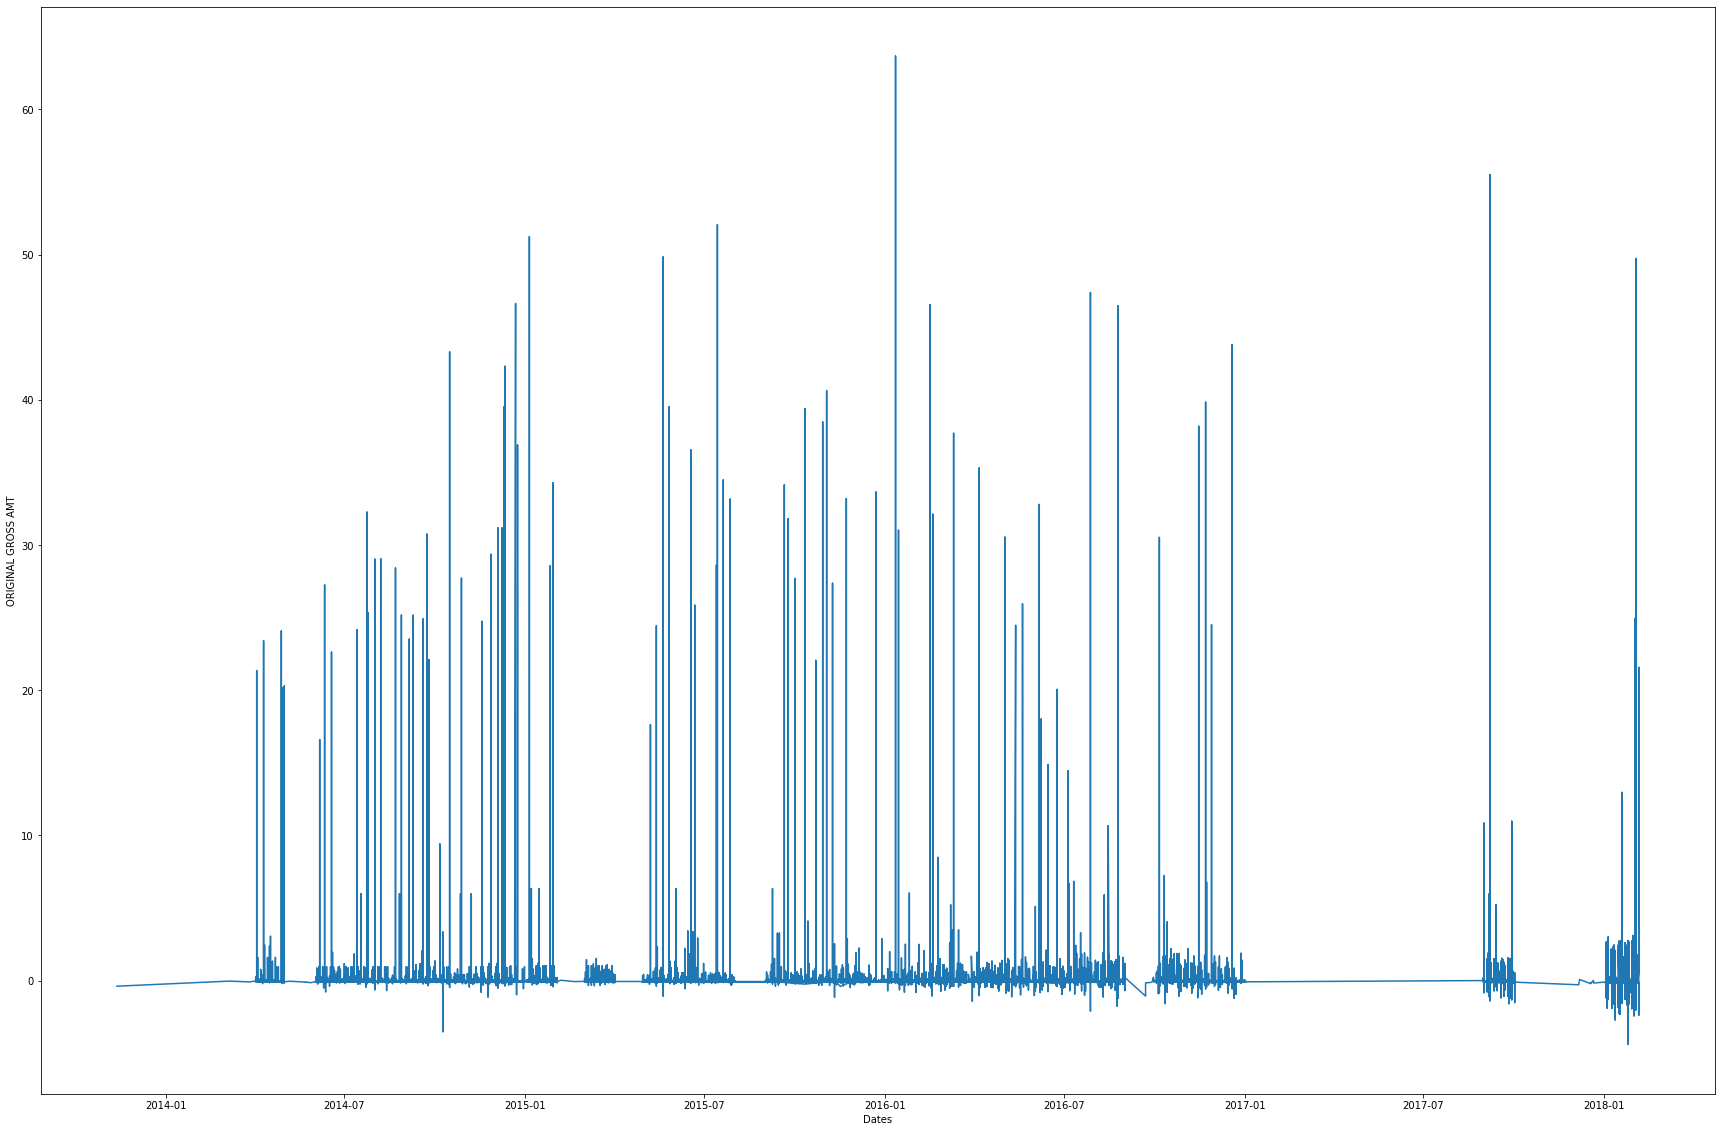

In [50]:
plt.figure(figsize=(30,20))
plt.plot(df['ORIGINAL GROSS AMT'])
plt.xlabel('Dates')
plt.ylabel('ORIGINAL GROSS AMT')

# 4 - Profiling / clustering for 2017-2018

#### Based on card number

In [51]:
### Converting categorical variables about cards into numerical ones
df_aux = df_2016
# Frequency of transactions made by each unique card
card_vc = df_aux['CARD NUMBER'].value_counts()

# Transforming it into a DataFrame
card_vc = pd.DataFrame(card_vc)
card_vc = card_vc.reset_index()
card_vc.columns = ['unique_card','counts']

In [52]:
card_vc

,unique_card,counts
0,************6740,426
1,************2968,389
2,************6308,309
3,************8192,303
4,************8343,301
...,...,...
1002,************8749,1
1003,************2272,1
1004,************7201,1
1005,************4368,1


In [53]:
df_aux['CARD NUMBER']

TRANS DATE
2015-06-25    ************6158
2015-09-18    ************4193
2015-10-12    ************0381
2015-11-04    ************7587
2015-11-14    ************0381
                    ...       
2017-01-02    ************7939
2017-01-02    ************5492
2017-01-02    ************3044
2017-01-02    ************7379
2017-01-02    ************4107
Name: CARD NUMBER, Length: 43973, dtype: object

In [54]:
len(df_aux['CARD NUMBER'])
print(df_aux['CARD NUMBER'][0])
print(card_vc['unique_card'][0])
print(df_aux['ORIGINAL GROSS AMT'][0])
print(card_vc['counts'][0])

************6158
************6740
-0.09968258042294809
426


In [55]:
# Average amount of transactions by each unique card
sum_tr = 0
card_trans = pd.DataFrame()
j = 0
for m in card_vc['unique_card']:
  for i in range(len(df_aux['CARD NUMBER'])):
    if df_aux['CARD NUMBER'][i] == m:
      sum_tr += df_aux['ORIGINAL GROSS AMT'][i]
  card_trans = card_trans.append([(sum_tr/card_vc['counts'][j])])
  j += 1

# Assembling previous data
card_data = pd.DataFrame()
card_data['card_name'] = card_vc['unique_card']
card_data['trans_avg'] = card_trans.values.reshape(-1,1)
card_data['frequency'] = card_vc['counts']

card_data = card_data.set_index(card_data.card_name)
card_data = card_data.drop(['card_name'], axis = 1)

card_data

,trans_avg,frequency
card_name,,
************6740,-5.520294e-02,426
************2968,1.824278e-02,389
************6308,4.345319e-01,309
************8192,4.012053e-01,303
************8343,3.350376e-01,301
...,...,...
************8749,1.777210e-01,1
************2272,1.101337e-01,1
************7201,1.508744e-01,1


Text(0, 0.5, 'Cluster inertia')

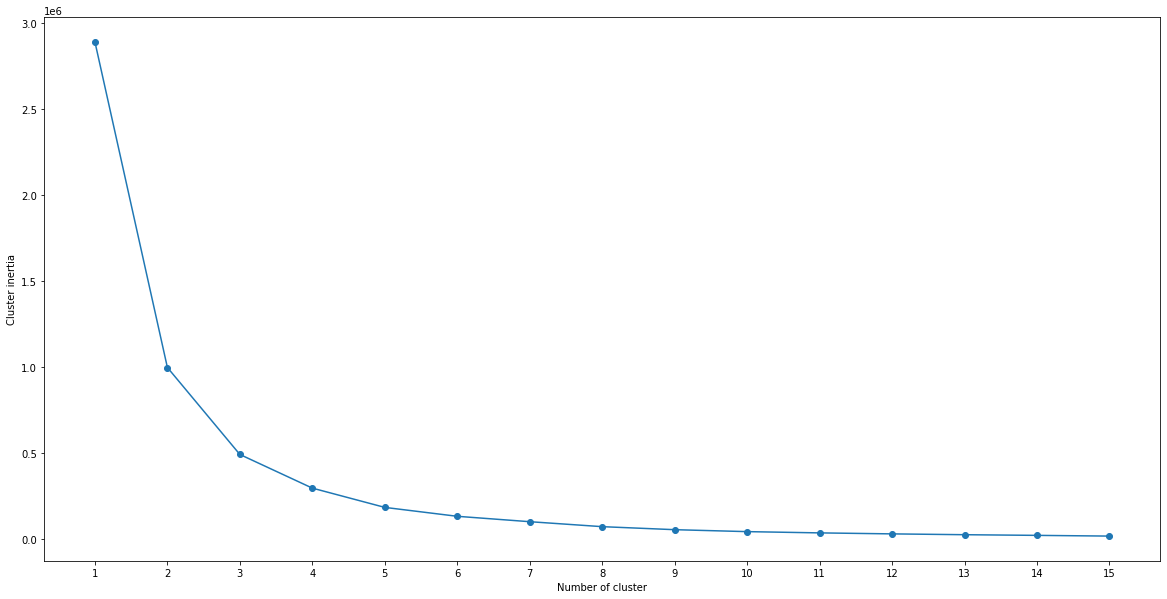

In [56]:
# Scaling the frequency of transactions by means amount of transactions
card_tr = card_data.values

# First we need to determine the optimal number of clusters
cluster_range = range(1,16)
cluster_error = []

for num in cluster_range:
    model = KMeans(num)
    model.fit(card_tr)
    cluster_error.append(model.inertia_)

df_clust = pd.DataFrame({'cluster_number':cluster_range,'cluster_error':cluster_error})


plt.figure(figsize=(20,10))
plt.xticks(range(1,16))
plt.plot(df_clust.cluster_number,df_clust.cluster_error, marker="o")
plt.xlabel("Number of cluster")
plt.ylabel("Cluster inertia")

Text(0, 0.5, 'The average transactions made by each person')

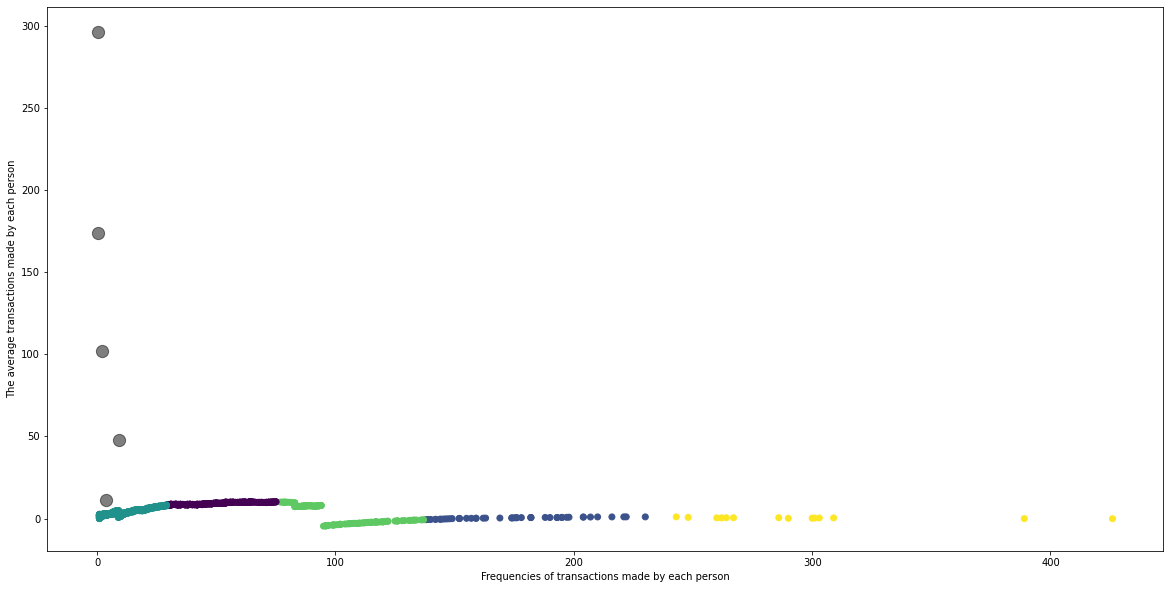

In [57]:
# The elbow graph showed us that 5 clusters is the optimal number
# so we'll start implementing the code

kmeans_model = KMeans(n_clusters=5)
kmeans_model.fit(card_tr)
kmeans_predict = kmeans_model.predict(card_tr)
kmeans_centroids = kmeans_model.cluster_centers_

plt.figure(figsize=(20,10))
plt.scatter(card_tr[:,1],card_tr[:,0], c=kmeans_predict)
plt.scatter(kmeans_centroids[:,0], kmeans_centroids[:,1], c='black', s=150, alpha=0.5)
plt.xlabel('Frequencies of transactions made by each person')
plt.ylabel('The average transactions made by each person')

#### Based on merchants

In [58]:
### Converting categorical variables about marchants into numerical ones

# Frequency of transactions made in favor of ech unique merchant
merchant_vc = df_aux['MERCHANT NAME'].value_counts()

# Transforming it into a DataFrame
merchant = pd.DataFrame(merchant_vc)
merchant = merchant.reset_index()
merchant.columns = ['unique_merchant','counts']
merchant

,unique_merchant,counts
0,amazon uk marketplace,5837
1,amazon uk retail,2182
2,travelodge website,1270
3,asda home shopping,858
4,amazon uk retail amazon.c,583
...,...,...
5879,paypal peeksofbmth,1
5880,mailord,1
5881,serious graphics ltd,1
5882,paypal advantagesi,1


In [59]:
print(len(df_aux['MERCHANT NAME']))
print(df_aux['MERCHANT NAME'][0])
print(df_aux['ORIGINAL GROSS AMT'][0])
print(merchant['counts'][0])

43973
the consortium/wms
-0.09968258042294809
5837


In [1]:
sum_tr = 0
merchant_trans = pd.DataFrame()
j = 0

# Average amount of transactions for each unique merchant
for m in merchant['unique_merchant']:
  print(m)
  for i in range(len(df_aux['MERCHANT NAME'])):
    print(i)
    print(df_aux['MERCHANT NAME'][i])
    if df_aux['MERCHANT NAME'][i] == m:
      print(df_aux['ORIGINAL GROSS AMT'][i])
      sum_tr += df_aux['ORIGINAL GROSS AMT'][i]
  print([(sum_tr/merchant['counts'][j])])
  merchant_trans = merchant_trans.append([(sum_tr/merchant['counts'][j])])
  j += 1

# Assembling previous data
merchant_data = pd.DataFrame()
merchant_data['merchant_name'] = merchant['unique_merchant']
merchant_data['trans_avg'] = merchant_trans.values.reshape(-1,1)
merchant_data['frequency'] = merchant['counts']

merchant_data = merchant_data.set_index(merchant_data.merchant_name)
merchant_data = merchant_data.drop(['merchant_name'], axis = 1)

merchant_data

NameError: ignored

Text(0, 0.5, 'Average transactions')

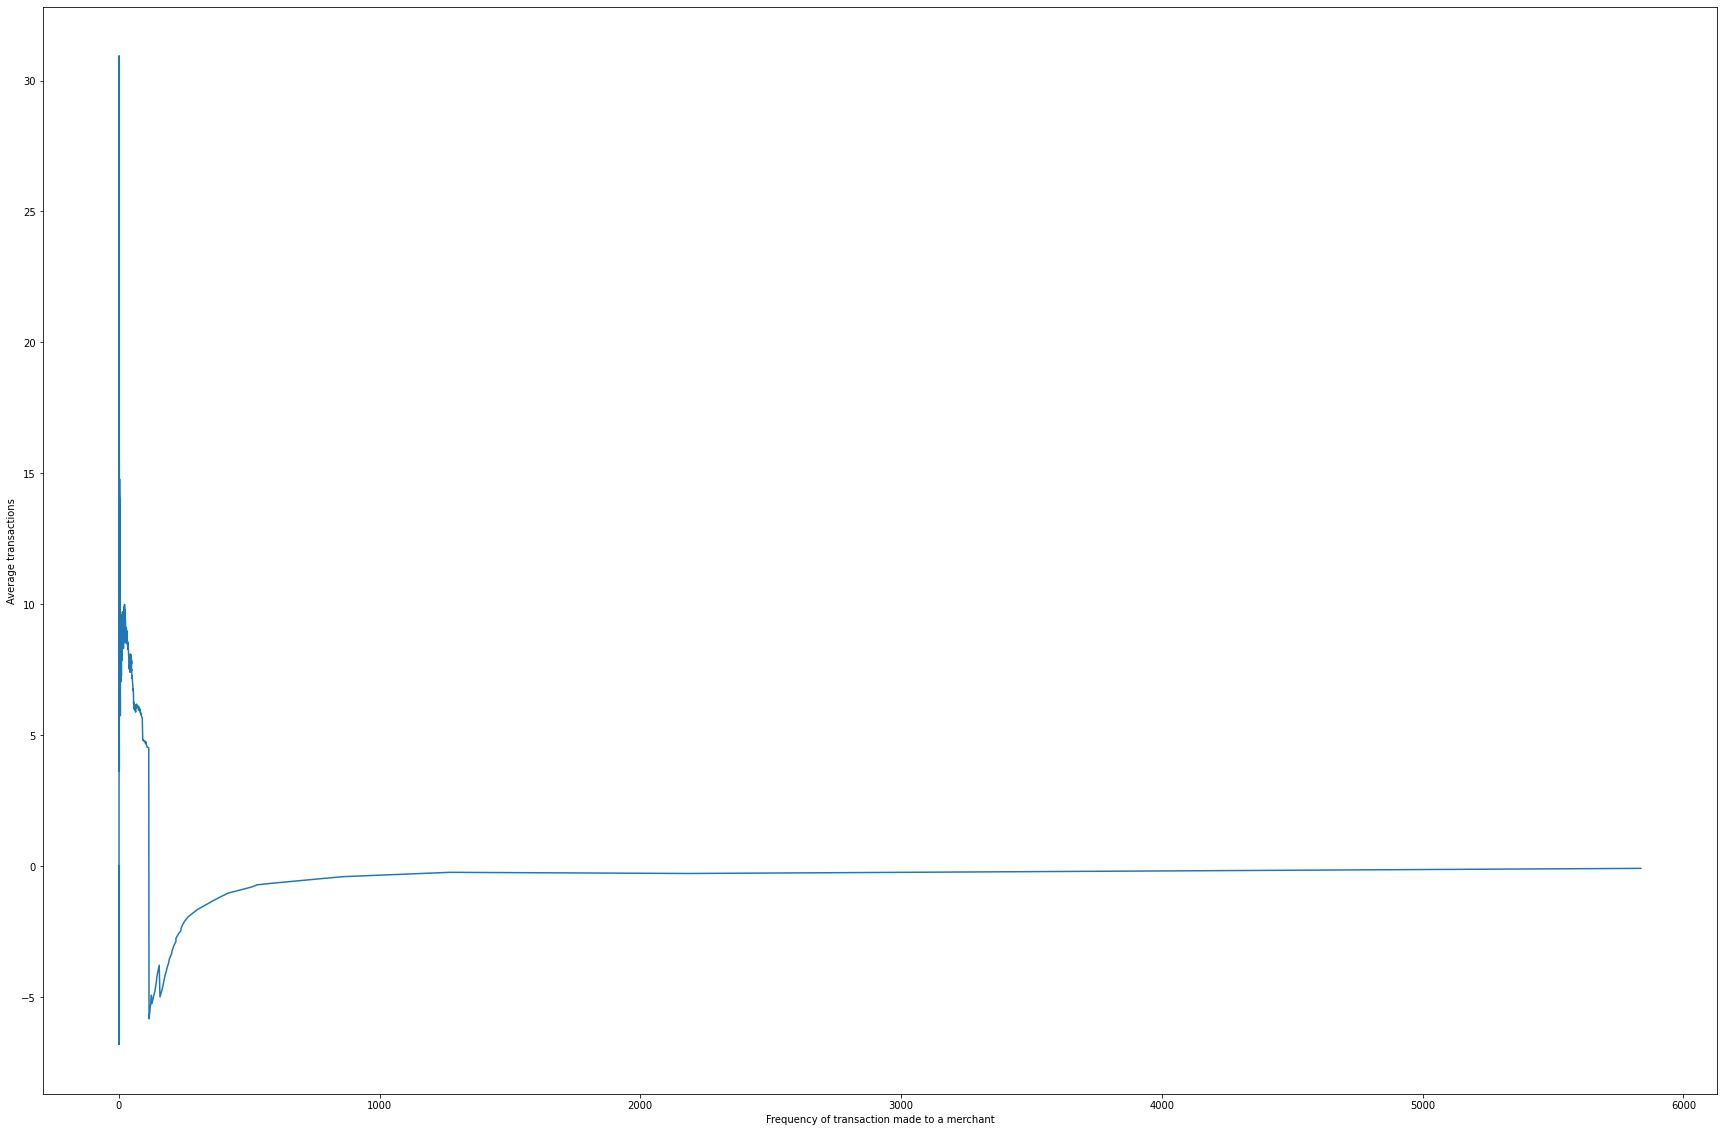

In [61]:
plt.figure(figsize=(30,20))
plt.plot(merchant_data.frequency,merchant_data.trans_avg)
plt.xlabel("Frequency of transaction made to a merchant")
plt.ylabel("Average transactions")

In [62]:
# The average number of merchants that receive negative average transactions
negative = 0
for i in range(len(merchant_data)):
    if merchant_data.trans_avg[i]<0:
        negative += 1
        
negativ_avg = negative/len(merchant_data)

negativ_avg

0.1733514615907546

Text(0, 0.5, 'Cluster inertia')

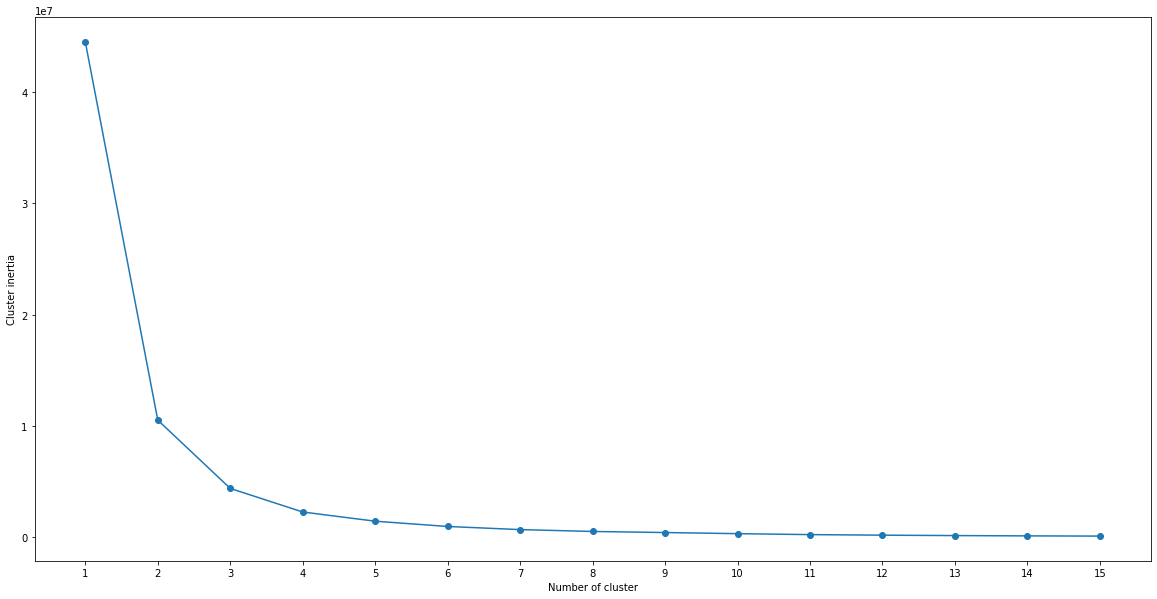

In [63]:
### Here we will do clustering using the KMeans algorithms
# Scaling the frequency of transactions by means amount of transactions
merchant_tr = merchant_data.values

# First we need to determine the optimal number of clusters
cluster_range = range(1,16)
cluster_error = []

for num in cluster_range:
    model = KMeans(num)
    model.fit(merchant_tr)
    cluster_error.append(model.inertia_)

df_clust = pd.DataFrame({'cluster_number':cluster_range,'cluster_error':cluster_error})


plt.figure(figsize=(20,10))
plt.xticks(range(1,16))
plt.plot(df_clust.cluster_number,df_clust.cluster_error, marker="o")
plt.xlabel("Number of cluster")
plt.ylabel("Cluster inertia")

Text(0, 0.5, 'The average transaction made by each merchant')

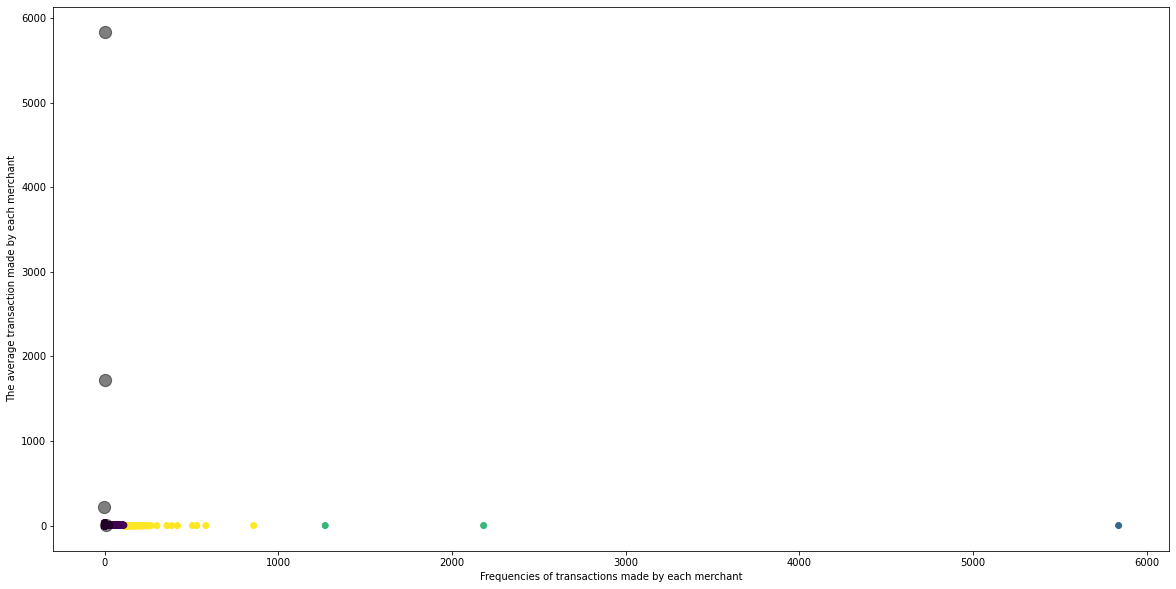

In [64]:
# The elbow graph showed us that 4 clusters is the optimal number
# so we'll start implementing the code

kmeans_model = KMeans(n_clusters=4)
kmeans_model.fit(merchant_tr)
kmeans_predict = kmeans_model.predict(merchant_tr)
kmeans_centroids = kmeans_model.cluster_centers_

plt.figure(figsize=(20,10))
plt.scatter(merchant_tr[:,1],merchant_tr[:,0], c=kmeans_predict)
plt.scatter(kmeans_centroids[:,0], kmeans_centroids[:,1], c='black', s=150, alpha=0.5)
plt.xlabel('Frequencies of transactions made by each merchant')
plt.ylabel('The average transaction made by each merchant')

### One-Class SVM

In [65]:
# Splitting the ORIGINAL GROSS AMOUNT time series data into training and testing datasets (70%+30%)

train_set = df_aux.iloc[0:int(len(df_aux)*0.7),1]
test_set = df_aux.iloc[int(len(df_aux)*0.7)+1:len(df_aux),1]

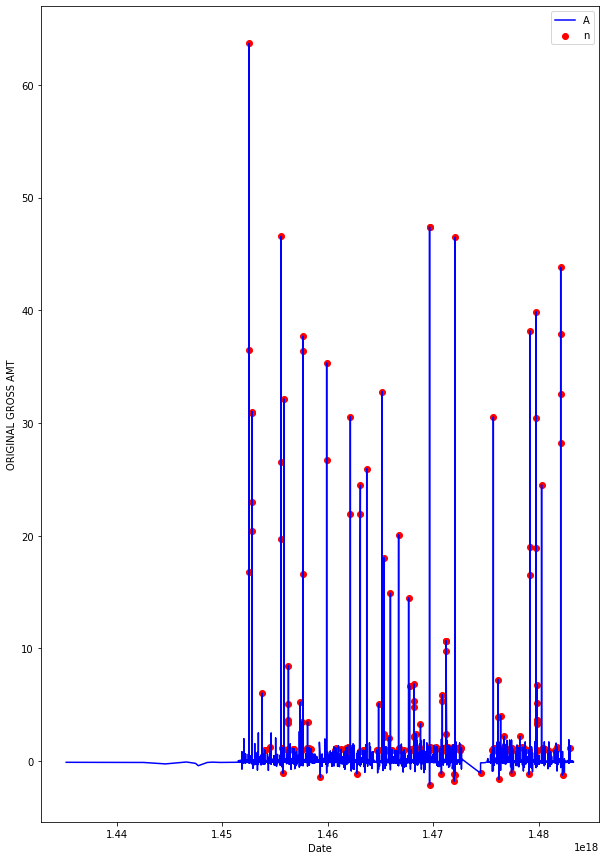

In [66]:
# Training the One-Class SVM model 

ocsvm_model = OneClassSVM(gamma ="auto",nu=0.0025).fit(df_aux['ORIGINAL GROSS AMT'].values.reshape(-1,1))
ocsvm_model.predict(df_aux['ORIGINAL GROSS AMT'].values.reshape(-1,1))
ocsvm_decision_func = ocsvm_model.decision_function(df_aux['ORIGINAL GROSS AMT'].values.reshape(-1,1))
ocsvm_score = ocsvm_model.score_samples(df_aux['ORIGINAL GROSS AMT'].values.reshape(-1,1))

df_aux['INT_TIME'] = df_aux.index.astype(np.int64)
df_aux['ocsvm_decis_func'] = ocsvm_decision_func
anomaly = df_aux.loc[df_aux['ocsvm_decis_func']<0, ['INT_TIME','ORIGINAL GROSS AMT']]
normal = df_aux.loc[df_aux['ocsvm_decis_func']>=0, ['INT_TIME','ORIGINAL GROSS AMT']]

fig, ax = plt.subplots(figsize=(10,15))
ax.plot(df_aux['INT_TIME'],df_aux['ORIGINAL GROSS AMT'], color='blue',label='Normal')
ax.scatter(anomaly['INT_TIME'],anomaly['ORIGINAL GROSS AMT'], color='red', label='Anomaly')

plt.xlabel('Date')
plt.ylabel('ORIGINAL GROSS AMT')
plt.legend('Anomaly detection using OCSVM')
plt.show()

In [67]:
anomaly_fraction = len(anomaly)/len(df_aux['ORIGINAL GROSS AMT'])
anomaly_fraction

0.004752916562436041

# 5 - Forecasting future transactional behavior

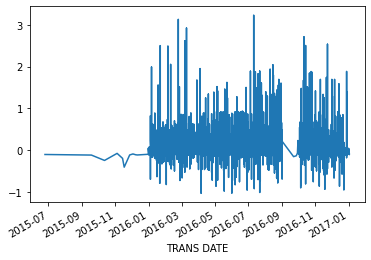

In [68]:
normal['ORIGINAL GROSS AMT'].plot()

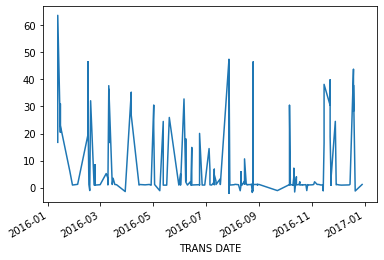

In [69]:
anomaly['ORIGINAL GROSS AMT'].plot()

In [70]:
# splitting training set and test test ona 70%:30% basis from the normal dataset extracted from oncsvm anomaly detection
normal_original_gross_amt = normal['ORIGINAL GROSS AMT']

train_set = normal.iloc[0:int(len(normal)*0.7),1]
train_set.index = pd.DatetimeIndex(train_set.index).to_period('D')
test_set = normal.iloc[int(len(normal)*0.3)+1:len(normal),1]
test_set.index = pd.DatetimeIndex(test_set.index).to_period('D')

A saída de streaming foi truncada nas últimas 5000 linhas.
predicted=-0.077442, expected=-0.091944
predicted=-0.091944, expected=-0.070427
predicted=-0.070427, expected=0.485270
predicted=0.485270, expected=-0.068226
predicted=-0.068226, expected=-0.082061
predicted=-0.082061, expected=0.252319
predicted=0.252319, expected=-0.057553
predicted=-0.057553, expected=-0.079708
predicted=-0.079708, expected=0.005239
predicted=0.005239, expected=-0.049198
predicted=-0.049198, expected=-0.059626
predicted=-0.059626, expected=-0.095924
predicted=-0.095924, expected=-0.061634
predicted=-0.061634, expected=-0.073296
predicted=-0.073296, expected=0.152626
predicted=0.152626, expected=-0.043747
predicted=-0.043747, expected=-0.073296
predicted=-0.073296, expected=0.108517
predicted=0.108517, expected=-0.090266
predicted=-0.090266, expected=-0.097753
predicted=-0.097753, expected=0.043609
predicted=0.043609, expected=0.410106
predicted=0.410106, expected=-0.018645
predicted=-0.018645, expected=-0.08

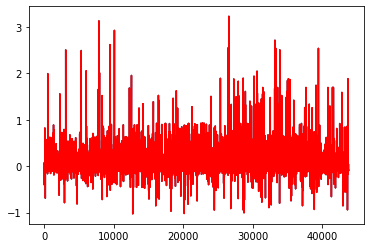

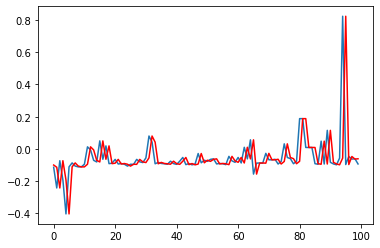

In [71]:
series = normal['ORIGINAL GROSS AMT']

X = series.values
window = 1
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()
# zoom plot
plt.plot(test[0:100])
plt.plot(predictions[0:100], color='red')
plt.show()

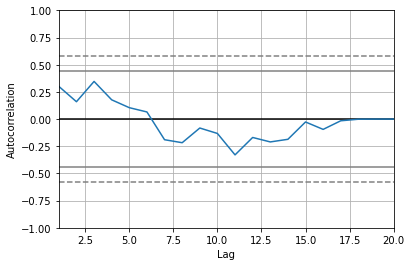

<Figure size 1800x1440 with 0 Axes>

In [72]:
# Forecasting using the ARIMA model
autocorrelation_plot(train_set[0:20])
plt.figure(figsize=(25,20))
plt.show()

In [ ]:
arima_model = ARIMA(train_set, order = (2,1,7))
arima_model_fit = arima_model.fit(transparams=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [ ]:
print(arima_model_fit.summary())

In [ ]:
history = [x for x in train_set]
predictions = list()
# walk-forward validation
for t in range(len(test_set)):
    model = ARIMA(history, order=(1,1,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_set[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test_set, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test_set)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
df_aux

In [ ]:
df_aux[['ORIGINAL GROSS AMT','ocsvm_decis_func']]

In [ ]:
df_aux_train = df_aux[['ORIGINAL GROSS AMT','ocsvm_decis_func']].sample(frac=0.7,random_state=0)
df_aux_test = df_aux[['ORIGINAL GROSS AMT','ocsvm_decis_func']].sample(frac=0.3,random_state=0)

In [ ]:
target_scaler_train = MinMaxScaler([0,1])
target_scaler_train.fit(np.array(df_aux_train['ORIGINAL GROSS AMT']).reshape(-1,1))

target_scaler_test = MinMaxScaler([0,1])
target_scaler_test.fit(np.array(df_aux_test['ORIGINAL GROSS AMT']).reshape(-1,1))

In [ ]:
feature_scaler_train = MinMaxScaler([0,1])
feature_scaler_train.fit(np.array(df_aux_train['ocsvm_decis_func']).reshape(-1,1))

feature_scaler_test = MinMaxScaler([0,1])
feature_scaler_test.fit(np.array(df_aux_test['ocsvm_decis_func']).reshape(-1,1))

In [ ]:
# multivariate mlp

 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
in_seq1 = df_aux_train['ORIGINAL GROSS AMT'].values
in_seq2 = df_aux_train['ocsvm_decis_func'].values
out_seq = df_aux_train['ORIGINAL GROSS AMT'].values
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

In [ ]:
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 5
# convert into input/output
X, y = split_sequences(dataset, n_steps)

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
# separate input data
X1 = X[:, :, 0]
X2 = X[:, :, 1]
# first input model
visible1 = Input(shape=(n_steps,))
dense1 = Dense(100, activation='relu')(visible1)
# second input model
visible2 = Input(shape=(n_steps,))
dense2 = Dense(100, activation='relu')(visible2)
# merge input models
merge = concatenate([dense1, dense2])
output = Dense(1)(merge)
model = Model(inputs=[visible1, visible2], outputs=output)
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit([X1, X2], y, epochs=500, verbose=0)

In [ ]:
# demonstrate prediction
# define test input sequence
test_in_seq1 = df_aux_test['ORIGINAL GROSS AMT'].values
test_in_seq2 = df_aux_test['ocsvm_decis_func'].values
test_out_seq = df_aux_test['ORIGINAL GROSS AMT'].values
# convert to [rows, columns] structure
test_in_seq1 = test_in_seq1.reshape((len(test_in_seq1), 1))
test_in_seq2 = test_in_seq2.reshape((len(test_in_seq2), 1))
test_out_seq = test_out_seq.reshape((len(test_out_seq), 1))
# horizontally stack columns
test_dataset = hstack((test_in_seq1, test_in_seq2, test_out_seq))
# choose a number of time steps
n_steps = 5
# convert into input/output
test_X, test_y = split_sequences(test_dataset, n_steps)

In [ ]:
test_X1 = test_X[:, :, 0]
test_X2 = test_X[:, :, 1]

In [ ]:
yhat = model.predict([test_X1, test_X2], verbose=0)
yhat_un = target_scaler_test.inverse_transform(yhat)
print(yhat_un)

In [ ]:
df_aux_test =  df_aux_test.iloc[0:len(yhat_un)]

In [ ]:
df_aux_test['predicted'] = yhat_un

In [ ]:
df_aux_test

In [ ]:
mlp_error = mean_squared_error(df_aux_test['ORIGINAL GROSS AMT'], df_aux_test['predicted'])
print('Test MSE: %.3f' % mlp_error)